In [1]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Otimização de Hiperpârametros

Como vimos na aula passada, o parâmetro *k* do classificador KNN controla o número de vizinhos que devem ser considerados para decidir o rótulo para uma nova instância. O caso bidimensional estudado mostra que a fronteira de decisão é claramente afetada pelo parâmetro *k*. Como consequência, os resultados mostraram que o desempenho do classificador no conjunto de teste também muda. Nesta aula vamos estudar uma abordagem bastante utilizada para escolher o valor de hiperparâmetros com base em um conjunto de validação e busca exaustiva no espaço dos hiperparâmetros.

Por uma questão de familiaridade, vamos trabalhar com a base de dados *iris*.

In [2]:
ds = load_iris(as_frame=True)
df = ds.frame
X = ds.data.values
y = ds.target.values

In [3]:
#Usar 80% da base de dados para treino e 20% para teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

#Colocar todos os atributos na mesma escala
ss = StandardScaler()
ss.fit(X_treino)
X_treino = ss.transform(X_treino)
X_teste = ss.transform(X_teste)

A primeira idéia que vem para selecionar o melhor *k* é simplesmente avaliar o resultado do KNN com vários valores para *k* no conjunto de teste:

In [4]:
acuracias = []
#Vamos testar os ks ímpares de 1 a 29
ks = list(range(1,30,2))

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_treino, y_treino)
    pred = knn.predict(X_teste)
    #armazenar a acurácia no conjunto de teste
    acuracias.append(accuracy_score(y_teste, pred))

Plotando as acurácias no conjunto de teste em função de *k*:

Melhor k no teste: 3 (acc=0.97)


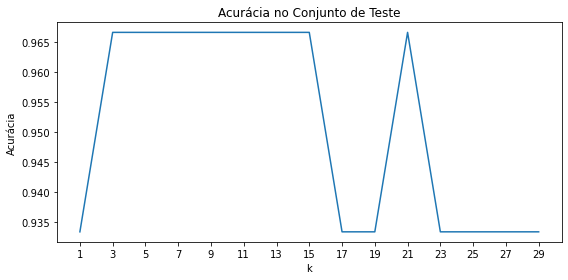

In [5]:
def plot_knn_k_acc(ks, acuracias, label=''):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(ks, acuracias)
    ax.set_xticks(ks)
    ax.set_xlabel('k')
    ax.set_ylabel('Acurácia')
    ax.set_title('Acurácia no Conjunto de %s' % (label))
    fig.tight_layout()
    plt.show()

melhor_teste = max(acuracias)
melhor_k_teste = ks[np.argmax(acuracias)]
print("Melhor k no teste: %d (acc=%.2f)" % (melhor_k_teste, melhor_teste))

plot_knn_k_acc(ks, acuracias, 'Teste')

Notamos que os melhores resultados obtidos (acurácia de 97%) foram com *k=3,5,7,9,11,13,15* e *21*. Por convenção, para desempatar o menor *k* é escolhido. 

Neste método usamos o conjunto de teste para escolher o melhor valor para *k*. É válido fazer isso?

# Usando conjunto de validação para otimização de hiperparâmetros

Lembre-se que o conjunto de teste deve ser utilizado apenas para avaliar o sistema de classificação. Escolher qualquer parâmetro do sistema com base nos resultados no conjunto de teste é um erro metodológico. É possível confiar que o valor escolhido para *k* funcionará bem em novas instâncias que não foram usadas para treinar o sistema! Veja que esta verificação é normalmente realizada com o conjunto de teste. Entretanto, este conjunto *já foi usado* para escolher o *k*. Como resolver este problema?

Ao invés de particionar a base de dados em apenas 2 partições (*treino* e *teste*), podemos particioná-la em 3 partições: *treino*, *teste* e **validação**. A idéia é que usamos o conjunto de validação para encontrar os melhores valores para os hiperparâmetros e o conjunto de teste é usado exclusivamente para avaliar o sistema de classificação como um todo.

In [6]:
ds = load_iris(as_frame=True)
df = ds.frame
X = ds.data.values
y = ds.target.values

#separamos normalmente os conjuntos de treino e teste a partir da base de dados completa
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

#Em seguida, separamos parte do conjunto de treino para a validação.
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, random_state=1)

ss = StandardScaler()
ss.fit(X_treino)
X_treino = ss.transform(X_treino)
X_teste = ss.transform(X_teste)
X_val = ss.transform(X_val)


Uma vez que temos os três conjuntos separados, podemos encontrar o valor de *k* que maximiza a acurácia no conjunto de *validação*.

Melhor k na validação: 7 (acc=0.96)


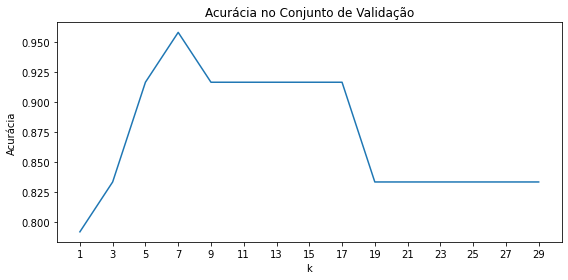

In [7]:
acuracias_val = []
ks = list(range(1,30,2))

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_treino, y_treino)
    pred = knn.predict(X_val)
    acuracias_val.append(accuracy_score(y_val, pred))

melhor_val = max(acuracias_val)
melhor_k = ks[np.argmax(acuracias_val)]
print("Melhor k na validação: %d (acc=%.2f)" % (melhor_k, melhor_val))
plot_knn_k_acc(ks, acuracias_val, 'Validação')

O grafico agora mostra a acurácia no conjunto de validação. Como a melhor acurácia aconteceu para *k=7*, este valor é adotado. Em seguida, verificamos a acurácia no conjunto de teste:

In [8]:
knn = KNeighborsClassifier(n_neighbors=melhor_k)
knn.fit(X_treino, y_treino)
pred = knn.predict(X_teste)
print("acurácia no teste: %.2f" % (accuracy_score(y_teste, pred)))


acurácia no teste: 0.97


Note que como não há pontos em comum entre o conjunto de validação e o conjunto de teste, nenhum ponto do conjunto de teste foi usado para escolher o valor de *k*. Portanto, sabemos que o valor de *k* escolhido generaliza bem para dados não utilizados no desenvolvimento do modelo. Este método de otimização de hiperparâmetros é amplamente utilizado na indústria e na academia.

Uma vez que o conjunto de validação é usado apenas para escolher o *k*, podemos utilizar os pontos do conjunto de validação como parte do conjunto de treinamento para gerar o modelo final. Embora não seja um requisito formal, não é incorreto. A idéia é fornecer mais exemplos para o algoritmo de aprendizagem, o que normalmente leva a resultados melhores.

In [9]:
knn = KNeighborsClassifier(n_neighbors=melhor_k)
#Note que aqui está sendo realizada uma união entre os conjuntos de treinamento e 
# validação para servir como conjunto de treinamento.
knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val]) 
pred = knn.predict(X_teste)
print("acurácia no teste: %.2f" % (accuracy_score(y_teste, pred)))

acurácia no teste: 0.97


O código abaixo simplesmente "empacota" o procedimento de escolher o melhor *k* usando um conjunto de validação.

In [10]:
def selecionar_melhor_k(ks, X_treino, X_val, y_treino, y_val):
    acuracias_val = []

    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_treino, y_treino)
        pred = knn.predict(X_val)
        acuracias_val.append(accuracy_score(y_val, pred))
        
    melhor_val = max(acuracias_val)
    melhor_k = ks[np.argmax(acuracias_val)]        
    knn = KNeighborsClassifier(n_neighbors=melhor_k)
    knn.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])
    
    return knn, melhor_k, melhor_val
    

knn, melhor_k, melhor_val = selecionar_melhor_k(range(1,30,2), X_treino, X_val, y_treino, y_val)
print("Melhor k na validação: %d (acc=%.2f)" % (melhor_k, melhor_val))

pred = knn.predict(X_teste)
print("acurácia no teste: %.2f" % (accuracy_score(y_teste, pred)))

Melhor k na validação: 7 (acc=0.96)
acurácia no teste: 0.97


# O efeito do particionamento da base de dados

Muitos particionamentos diferentes da base de dados em conjuntos de treino, teste e validação são possíveis. Desta observação vem uma questão importante: existe um particionamento melhor para usar? Antes de responder esta pergunta, vamos explorar o que acontece com o desempenho do sistema estudado nesta aula usando particionamentos diferentes.


In [27]:
n_particoes = 100
rs = np.random.RandomState(1)
random_states = np.arange(n_particoes*100)
rs.shuffle(random_states)
random_states = random_states[:n_particoes]

acuracias = []

for r in random_states:
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, stratify=y, random_state=r)
    
    X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size=0.2, stratify=y_treino, random_state=1)

    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)
    X_val = ss.transform(X_val)
    
    knn, _, _ = selecionar_melhor_k(range(1,30,2), X_treino, X_val, y_treino, y_val)
    
    pred = knn.predict(X_teste)
    acuracias.append(accuracy_score(y_teste, pred))

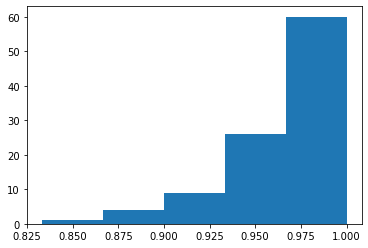

min: 0.833, max: 1.000, média+-desv: 0.954 +- 0.036


In [28]:
plt.hist(acuracias, bins=5)
plt.show()
print("min: %.3f, max: %.3f, média+-desv: %.3f +- %.3f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))

Os resultados apresentados acima mostram que alguns particionamentos levam a resultados melhores que os outros. Entretanto, sabemos que independente do melhor resultado que podemos obter no conjunto de teste, ele não vai necessariamente representar todos os dados que o modelo poderá ter que classificar no futuro. Desta forma, otimizar o particionamento em si não faz muito sentido.

O importante é ter uma estimativa do desempenho do modelo no mundo real. Isto nos permite comparar diferentes modelos para escolher aquele que tem a melhor chance de funcionar melhor. Na próxima aula vamos estudar a validação cruzada em k-vias, um protocolo para estimar o desempenho do modelo no mundo real usando vários particionamentos.

<!-- Ajeitar o texto abaixo:

Aparentemente alguns particionamentos levam a resultados melhores que outros.. Mas e no mundo real? Na média, que tipo de desempenho podemos esperar de um modelo desenvolvido com os dados que temos disponíveis? O resultado médio obtido nos dá uma idéia do que esperar. Entretanto, há algumas falhas no método. Na aula que vem vamos estudar um método para estimar o desempenho médio esperado do modelo chamado de Validação Cruzada.  -->